In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import jax
import optax
import jaxopt
from flax import linen as nn
from jax import numpy as jnp
from flax.training import train_state  # Useful dataclass to keep train state
import flax

from functools import partial
import pickle

from numerical_methods import physics

In [2]:
dx, dy = 0.5, 0.5
ny, nx = 26, 49
dt=0.1

## Dataset

In [3]:
TIMES = jnp.load("dataset/times.npy")

TERRAIN = jnp.load("dataset/terrain.npy")

INFLOW_LOCS = jnp.load("dataset/inflow_locations.npy")

rel_loc = [(0, -1), (0, 0), (1, -1), (1, 0)]
INFLOW_COEFFS = jnp.load("dataset/inflow_poly_coeffs.npy")

TRAIN_SET = jnp.load("dataset/train_smoke_grid.npy")

VELOCITY = jnp.load("dataset/velocity_2d.npy")

In [4]:
with open('ckpt/phase_2/unet/params_physics.pickle', 'rb') as handle:
    params_physics = pickle.load(handle)

## Neurcal Network

In [5]:
class UNet(nn.Module):
    features: int = 16

    def setup(self):
        self.encoder1 = self._conv_block(self.features)
        self.encoder2 = self._conv_block(self.features * 2)
        self.encoder3 = self._conv_block(self.features * 4)
        self.encoder4 = self._conv_block(self.features * 8)

        self.bottleneck = self._conv_block(self.features * 16)

        self.upconv4 = self._upconv_block(self.features * 8)
        self.upconv3 = self._upconv_block(self.features * 4)
        self.upconv2 = self._upconv_block(self.features * 2)
        self.upconv1 = self._upconv_block(self.features)

        self.final_conv = nn.Conv(
            features=1, kernel_size=(1, 1), kernel_init=nn.initializers.xavier_uniform(), use_bias=True
        )

    def _conv_block(self, features):
        return nn.Sequential([
            nn.Conv(features, kernel_size=(3, 3), padding='SAME', kernel_init=nn.initializers.xavier_uniform()),
            nn.relu,
            nn.Conv(features, kernel_size=(3, 3), padding='SAME', kernel_init=nn.initializers.xavier_uniform()),
            nn.relu
        ])

    def _upconv_block(self, features):
        return nn.Sequential([
            nn.ConvTranspose(features, kernel_size=(2, 2), strides=(2, 2), padding='VALID', kernel_init=nn.initializers.xavier_uniform()),
            nn.relu
        ])

    def __call__(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.max_pool(enc1, window_shape=(2, 3), strides=(2, 3)))
        enc3 = self.encoder3(nn.max_pool(enc2, window_shape=(2, 3), strides=(2, 3)))
        enc4 = self.encoder4(nn.max_pool(enc3, window_shape=(2, 2), strides=(2, 2)))

        # Bottleneck
        bottleneck = self.bottleneck(nn.max_pool(enc4, window_shape=(2, 2), strides=(2, 2)))
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = jax.image.resize(dec4, shape=(1, enc4.shape[1], enc4.shape[2], dec4.shape[-1]), method='bilinear')
        dec4 = jnp.concatenate([dec4, enc4], axis=-1)

        dec3 = self.upconv3(dec4)
        dec3 = jax.image.resize(dec3, shape=(1, enc3.shape[1], enc3.shape[2], dec3.shape[-1]), method='bilinear')
        dec3 = jnp.concatenate([dec3, enc3], axis=-1)

        dec2 = self.upconv2(dec3)
        dec2 = jax.image.resize(dec2, shape=(1, enc2.shape[1], enc2.shape[2], dec2.shape[-1]), method='bilinear')
        dec2 = jnp.concatenate([dec2, enc2], axis=-1)

        dec1 = self.upconv1(dec2)
        dec1 = jax.image.resize(dec1, shape=(1, enc1.shape[1], enc1.shape[2], dec1.shape[-1]), method='bilinear')
        dec1 = jnp.concatenate([dec1, enc1], axis=-1)

        output = self.final_conv(dec1)

        return output

In [6]:
hidden_net = UNet(features=16)
closure_net = UNet(features=8)

## Forward Simulation Function

In [7]:
@jax.jit
def conv_diff_single_step(params_rcnn,
                          params_physics,
                          smoke_initial: jnp.array,
                          hidden_state: jnp.array,
                          velocity: jnp.array,
                          time_curr: float,
                          inflow_loc: jnp.array,
                          inflow_poly_coeffs: jnp.array,
                          terrain: jnp.array,
                          dt: float):

    # set smoke at inflow locations
    y,x = inflow_loc
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_curr)
        smoke_initial = smoke_initial.at[y+rel_y, x+rel_x].set(c)

    advection_term = physics.advect_corr_fvm(field=smoke_initial,
                                             velocity=velocity,
                                             u_corr=params_physics['u_corr'],
                                             v_corr=params_physics['v_corr'],
                                             dx=dx,
                                             dy=dy) * dt

    diffusion_term = physics.diffuse_2d_fvm(field=smoke_initial,
                                            diffusivity_x=params_physics['diffusivity_x'],
                                            diffusivity_y=params_physics['diffusivity_y'],
                                            dx=dx,
                                            dy=dy) * dt


    # compute closure term
    input = jnp.stack(((smoke_initial-jnp.mean(smoke_initial))/jnp.std(smoke_initial),
                        (advection_term-jnp.mean(advection_term))/jnp.std(advection_term),
                        (diffusion_term-jnp.mean(diffusion_term))/jnp.std(diffusion_term),
                        TERRAIN,
                        hidden_state), axis=-1)
    input = jnp.expand_dims(input, 0)

    output = closure_net.apply({'params': params_rcnn['closure']}, input)
    closure_term = output * 1e-9        # a denormalization value, from previous tests

    smoke_pred = smoke_initial\
                    + advection_term\
                    + diffusion_term\
                    + closure_term.squeeze()

    time_next = time_curr + dt
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_next)
        smoke_pred = smoke_pred.at[y+rel_y, x+rel_x].set(c)

    smoke_pred = smoke_pred * terrain
    smoke_pred = jnp.maximum(smoke_pred, 0.0)

    # update hidden state
    mean = jnp.mean(smoke_pred)
    std = jnp.std(smoke_pred)
    input = jnp.stack(((smoke_pred-mean)/std, hidden_state), axis=-1)
    input = jnp.expand_dims(input, 0)
    output = hidden_net.apply({'params': params_rcnn['hidden']}, input)

    hidden_pred = output.squeeze()

    return (smoke_pred, hidden_pred, time_next, params_rcnn, inflow_loc, inflow_poly_coeffs), None


step_for_loop = lambda carry, x: conv_diff_single_step(params_rcnn=carry[3],
                                                       params_physics=params_physics,
                                                        smoke_initial=carry[0],
                                                        hidden_state=carry[1],
                                                        velocity=VELOCITY,
                                                        time_curr=carry[2],
                                                        inflow_loc=carry[4],
                                                        inflow_poly_coeffs=carry[5],
                                                        terrain=TERRAIN,
                                                        dt=dt)

@partial(jax.jit, static_argnames=['nsteps'])
def conv_diff_nsteps(params,
                     smoke_initial: jnp.array,
                     hidden_initial: jnp.array,
                     time_initial,
                     inflow_loc,
                     inflow_poly_coeffs,
                     nsteps):
    (smoke_pred, hidden_pred, _, params, _, _), _ = jax.lax.scan(step_for_loop, (smoke_initial, hidden_initial, time_initial, params, inflow_loc, inflow_poly_coeffs), xs=None, length=nsteps)
    return smoke_pred, hidden_pred

## Forward Simulation

In [8]:
def create_train_state(learning_rate):
    params = {}
    params['closure'] = closure_net.init(jax.random.PRNGKey(0), jnp.zeros((1, ny, nx, 5)))['params']
    params['hidden'] = hidden_net.init(jax.random.PRNGKey(0), jnp.zeros((1, ny, nx, 2)))['params']

    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=conv_diff_nsteps,
                                         params=params,
                                         tx=tx)

state = create_train_state(learning_rate=1e-4)

with open('ckpt/phase_2/unet/v1_1_phase2_unet_min.pickle', 'rb') as bunch:
    state_dict = pickle.load(bunch)

state = flax.serialization.from_state_dict(state, state_dict)

In [9]:
# with open('params_physics.pickle', 'wb') as handle:
#     pickle.dump(state.params, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('params_rcnn.pickle', 'wb') as handle:
#     pickle.dump(state.params, handle, protocol=pickle.HIGHEST_PROTOCOL)

Text(0.5, 1.0, 'v corection')

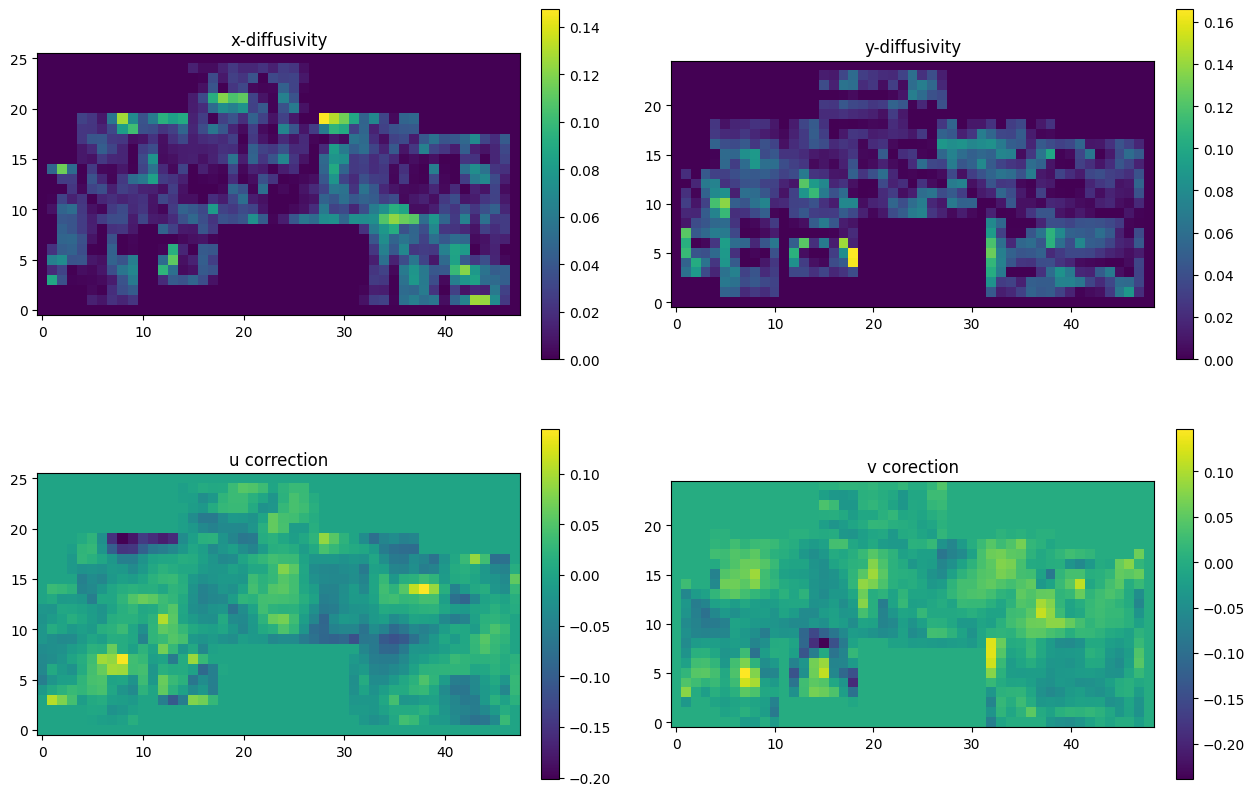

In [9]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,2,1)
im = plt.imshow(params_physics['diffusivity_x'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("x-diffusivity")
fig.add_subplot(2,2,2)
im = plt.imshow(params_physics['diffusivity_y'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("y-diffusivity")
fig.add_subplot(2,2,3)
im = plt.imshow(params_physics['u_corr'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("u correction")
fig.add_subplot(2,2,4)
im = plt.imshow(params_physics['v_corr'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("v corection")


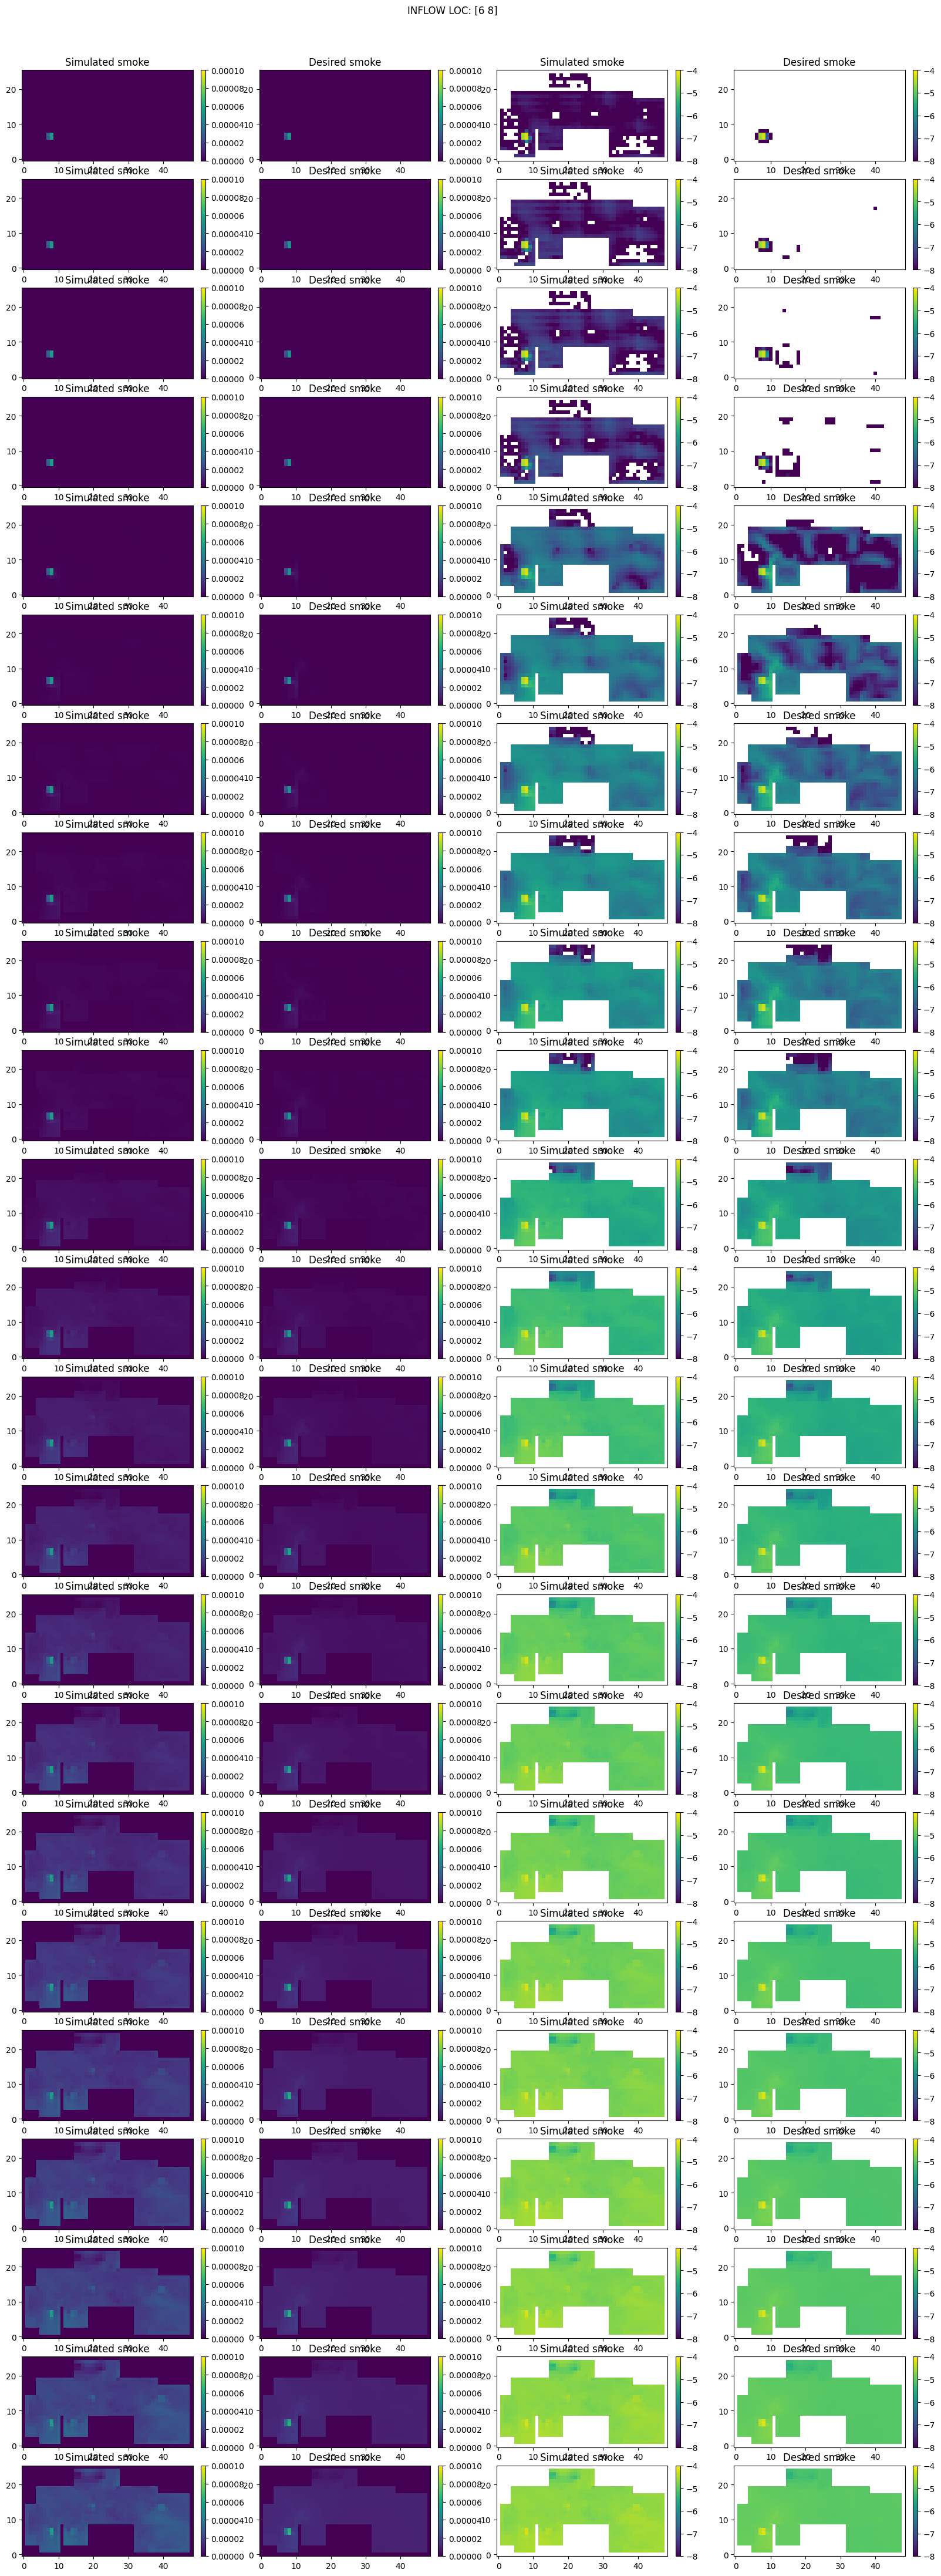

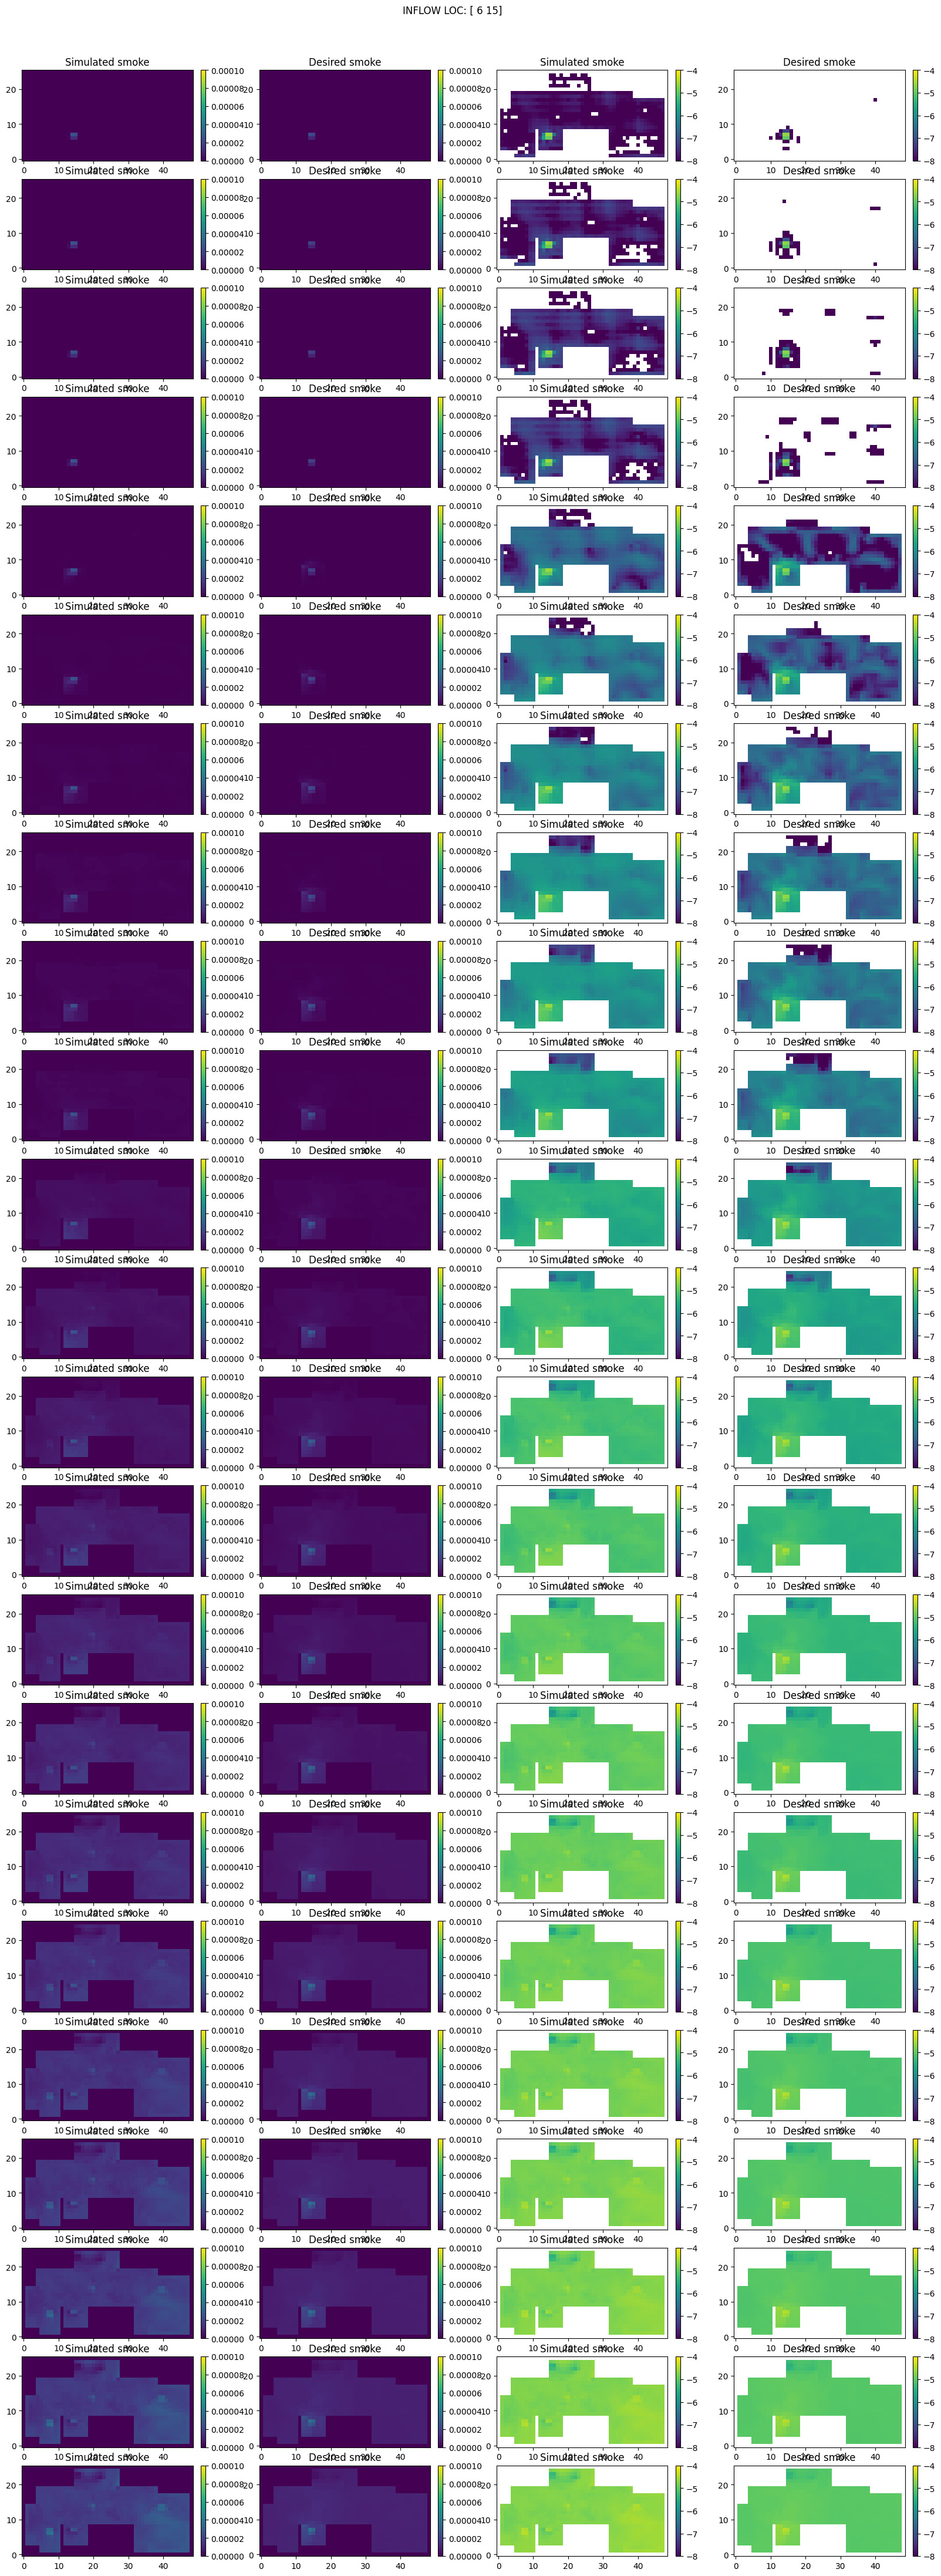

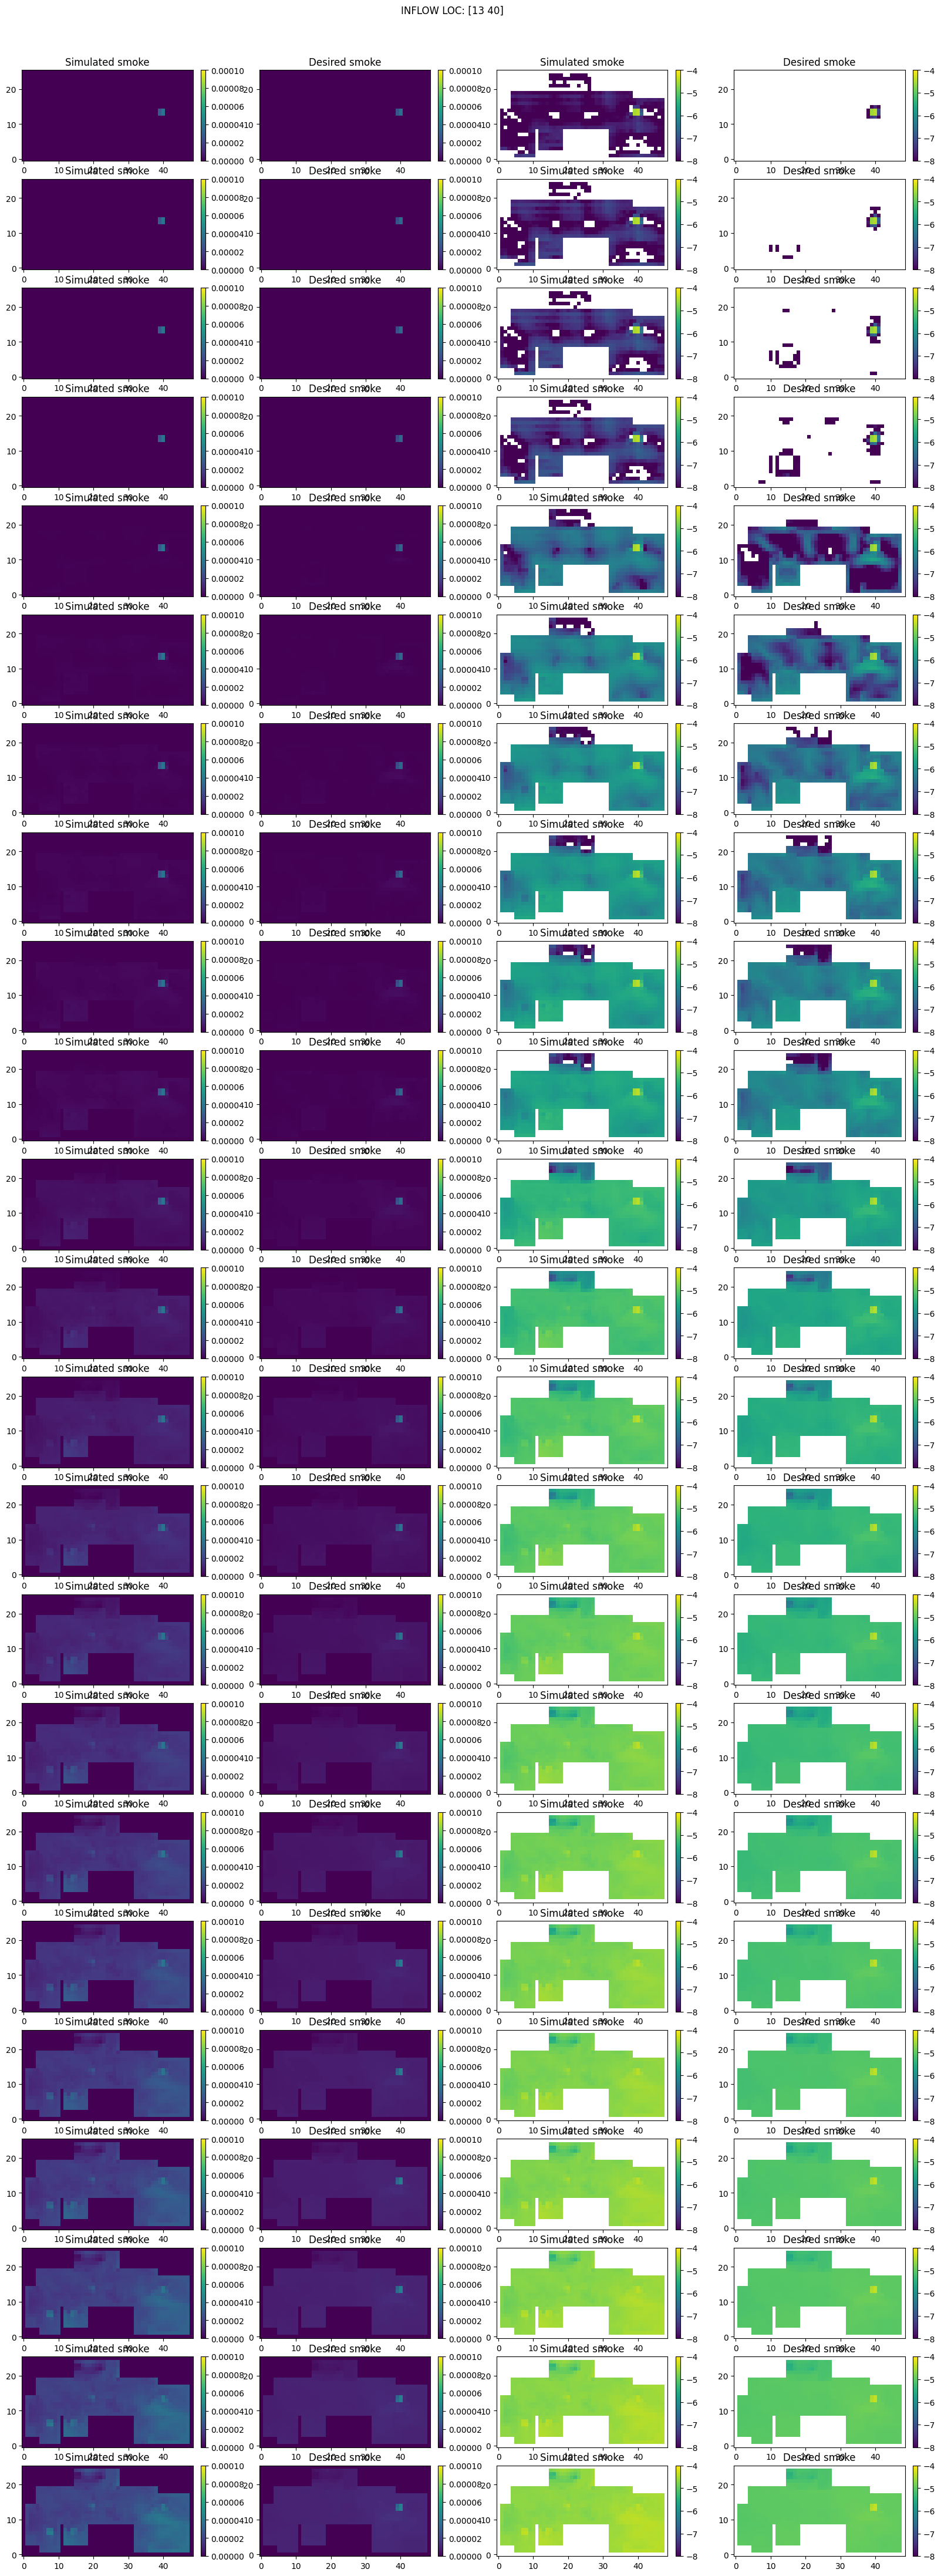

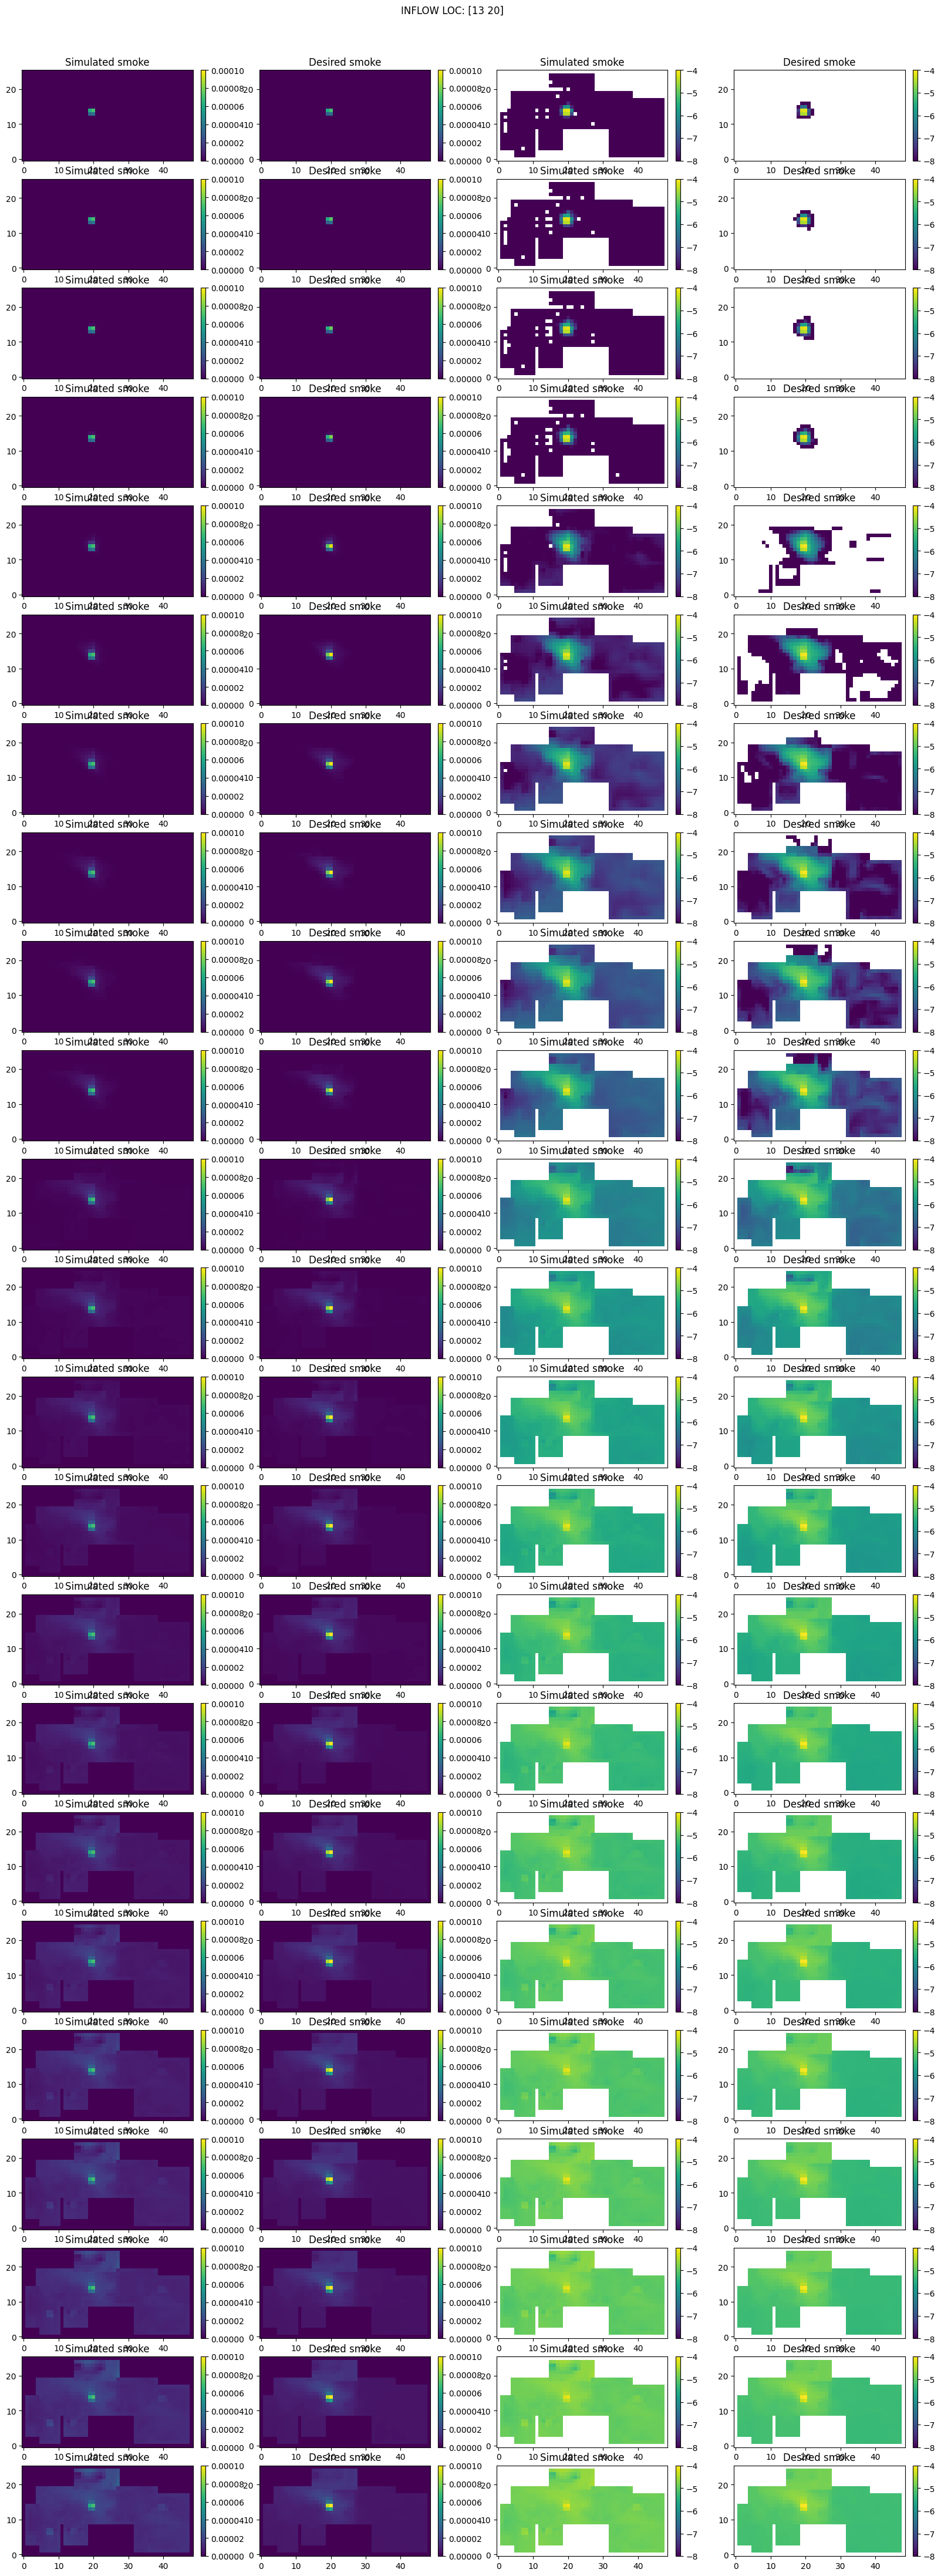

In [11]:
losses_all_set = []

for set_idx in range(len(TRAIN_SET)):
    losses = []
    smoke_curr = TRAIN_SET[set_idx][0]
    time_curr = TIMES[0]
    hidden_curr = jnp.zeros((ny,nx))
    fig = plt.figure(figsize=(20,55))
    plt.suptitle(f"INFLOW LOC: {INFLOW_LOCS[set_idx]}", y=0.9)
    for i in range(23):
        nsteps = int((TIMES[i+1]-TIMES[i]+1e-3)/dt)
        for j in range(nsteps):
            (smoke_curr, hidden_curr, _, _, _, _), _ = \
            conv_diff_single_step(params_rcnn=state.params,
                                  params_physics=params_physics,
                                smoke_initial=smoke_curr,
                                hidden_state=hidden_curr,
                                velocity=VELOCITY,
                                time_curr=time_curr,
                                inflow_loc=INFLOW_LOCS[set_idx],
                                inflow_poly_coeffs=INFLOW_COEFFS[set_idx],
                                terrain=TERRAIN,
                                dt=dt)
        
        
        fig.add_subplot(23,4,i*4+1)
        im = plt.imshow(smoke_curr, vmin=0, vmax=1e-4, origin='lower')
        plt.title("Simulated smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+2)
        im = plt.imshow(TRAIN_SET[set_idx][i+1], vmin=0, vmax=1e-4, origin='lower')
        plt.title("Desired smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+3)
        im = plt.imshow(jnp.log10(smoke_curr), vmin=-8, vmax=-4, origin='lower')
        plt.title("Simulated smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+4)
        im = plt.imshow(jnp.log10(TRAIN_SET[set_idx][i+1]), vmin=-8, vmax=-4, origin='lower')
        plt.title("Desired smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        losses.append(jnp.sum(optax.l2_loss(smoke_curr, TRAIN_SET[set_idx][i+1])))

    plt.show()

    losses_all_set.append(losses)
    

Text(0, 0.5, 'Loss')

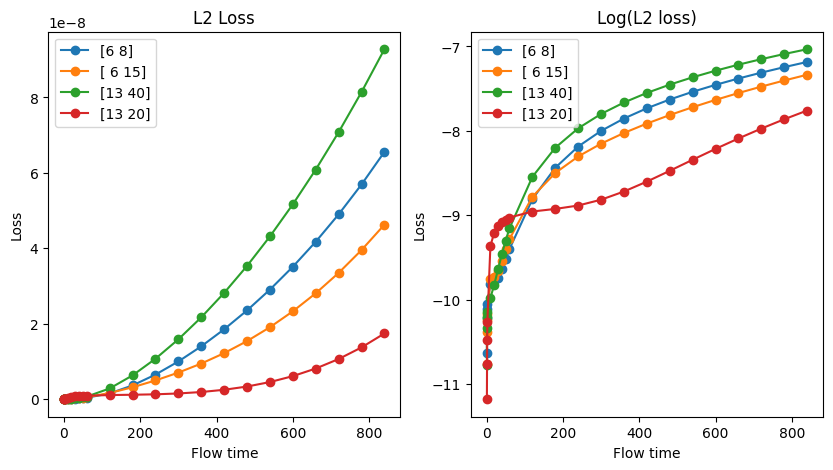

In [12]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.title("L2 Loss")
for i in range(len(losses_all_set)):
    plt.plot(TIMES[1:], losses_all_set[i], marker='o', label=f"{INFLOW_LOCS[i]}")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")
fig.add_subplot(1,2,2)
plt.title("Log(L2 loss)")
for i in range(len(losses_all_set)):
    plt.plot(TIMES[1:], np.log10(losses_all_set[i]), marker='o', label=f"{INFLOW_LOCS[i]}")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")

## Test set

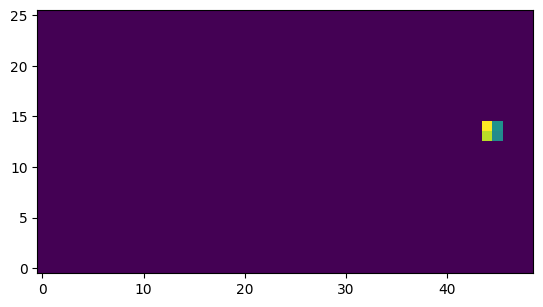

In [41]:
test_grid = jnp.load("dataset/grid_np/45_13_np.npy")[:24]
plt.imshow(test_grid[0], origin='lower')

In [31]:
test_grid.shape

(24, 26, 49, 1)

/tmp/ipykernel_3859/2708487129.py:10: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(TIMES, conc, deg=24)
/tmp/ipykernel_3859/2708487129.py:10: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(TIMES, conc, deg=24)
/tmp/ipykernel_3859/2708487129.py:10: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(TIMES, conc, deg=24)
/tmp/ipykernel_3859/2708487129.py:10: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(TIMES, conc, deg=24)


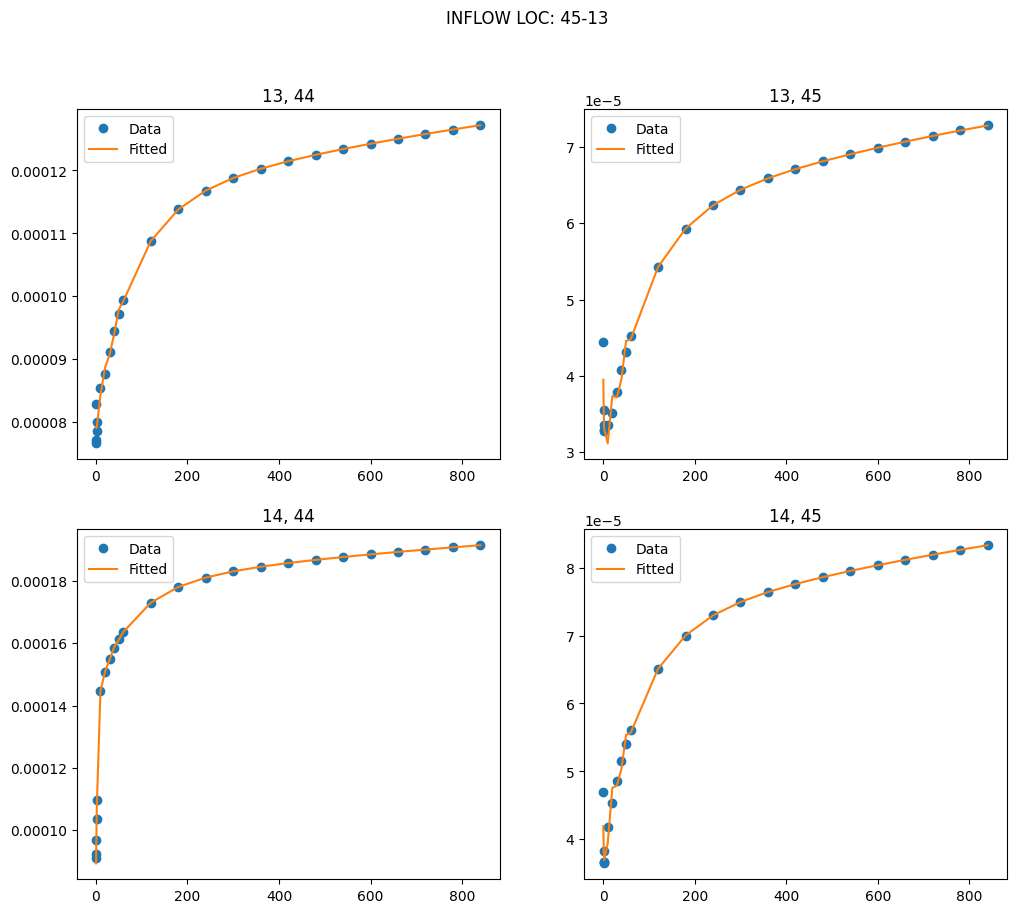

In [42]:
fig = plt.figure(figsize=(12,10))
fig.suptitle(f"INFLOW LOC: 45-13")
y,x = 13,45

p_all = np.zeros((4, 24+1))
for j in range(len(rel_loc)):
    rel_y, rel_x = rel_loc[j]

    conc = test_grid[:,y+rel_y,x+rel_x,0]
    p = np.polyfit(TIMES, conc, deg=24)
    p_all[j] = p
    fig.add_subplot(2,2,j+1)
    plt.plot(TIMES, conc, marker='o', linestyle='None', label='Data')
    plt.plot(TIMES, np.polyval(p, TIMES), label='Fitted')
    plt.title(f"{y+rel_y}, {x+rel_x}")
    plt.legend()
plt.show()

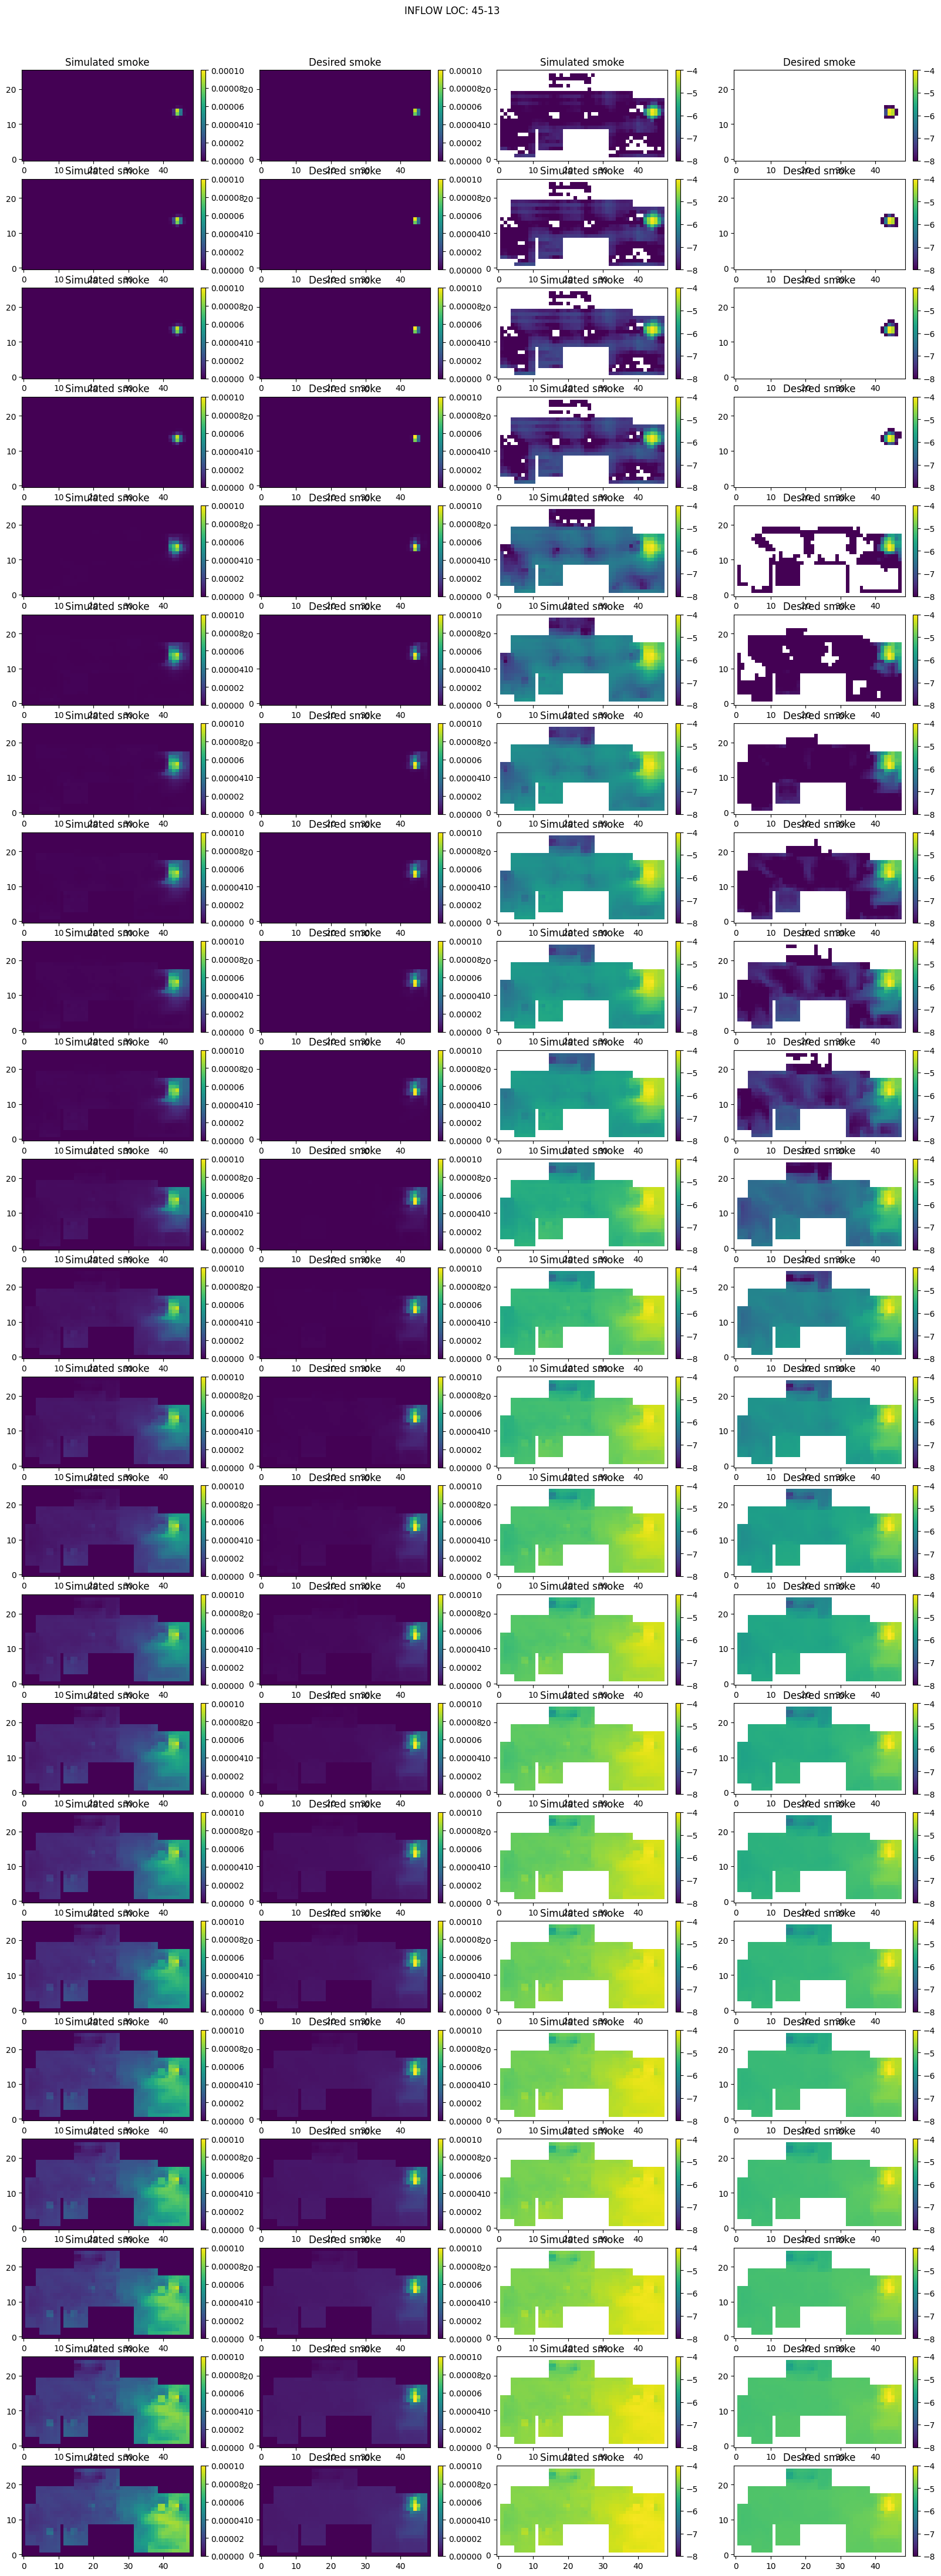

In [44]:
losses = []
rel_loss = []

smoke_curr = test_grid[0,:,:,0]
time_curr = TIMES[0]
hidden_curr = jnp.zeros((ny,nx))

fig = plt.figure(figsize=(20,55))
plt.suptitle(f"INFLOW LOC: 45-13", y=0.9)
for i in range(23):
    nsteps = int((TIMES[i+1]-TIMES[i]+1e-3)/dt)
    for j in range(nsteps):
        (smoke_curr, hidden_curr, _, _, _, _), _ = \
        conv_diff_single_step(params_rcnn=state.params,
                                params_physics=params_physics,
                            smoke_initial=smoke_curr,
                            hidden_state=hidden_curr,
                            velocity=VELOCITY,
                            time_curr=time_curr,
                            inflow_loc=jnp.array([13,45]),
                            inflow_poly_coeffs=p_all,
                            terrain=TERRAIN,
                            dt=dt)
    
    
    fig.add_subplot(23,4,i*4+1)
    im = plt.imshow(smoke_curr, vmin=0, vmax=1e-4, origin='lower')
    plt.title("Simulated smoke")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    fig.add_subplot(23,4,i*4+2)
    im = plt.imshow(test_grid[i+1,:,:,0], vmin=0, vmax=1e-4, origin='lower')
    plt.title("Desired smoke")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    fig.add_subplot(23,4,i*4+3)
    im = plt.imshow(jnp.log10(smoke_curr), vmin=-8, vmax=-4, origin='lower')
    plt.title("Simulated smoke")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    fig.add_subplot(23,4,i*4+4)
    im = plt.imshow(jnp.log10(test_grid[i+1,:,:,0]), vmin=-8, vmax=-4, origin='lower')
    plt.title("Desired smoke")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    denom = jnp.maximum(smoke_curr, test_grid[i+1,:,:,0])
    denom = jnp.where(denom<1e-8, 1.0, denom)
    loss = jnp.mean(optax.l2_loss(smoke_curr, test_grid[i+1,:,:,0])/denom**2)
    losses.append(jnp.sum(optax.l2_loss(smoke_curr, test_grid[i+1,:,:,0])))
    rel_loss.append(loss)


plt.show()


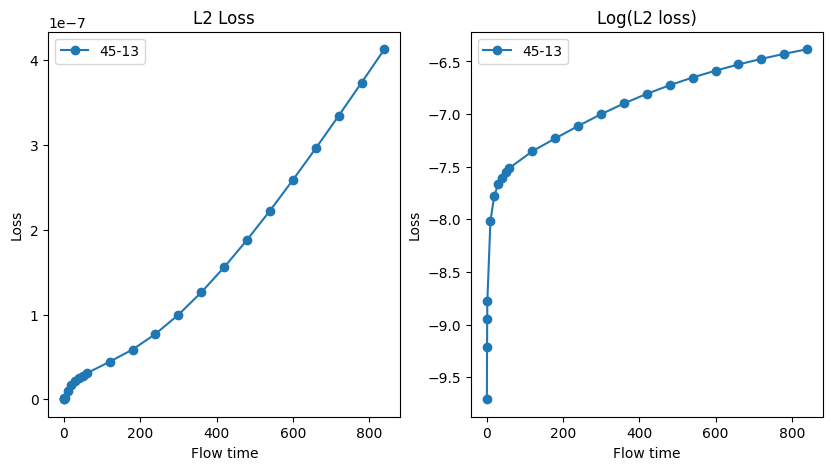

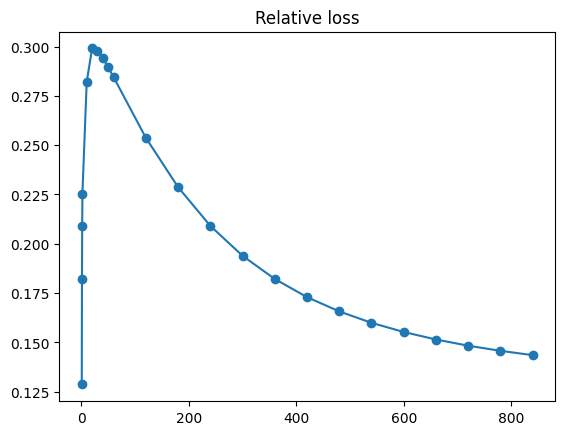

In [46]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.title("L2 Loss")
plt.plot(TIMES[1:], losses, marker='o', label=f"45-13")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")
fig.add_subplot(1,2,2)
plt.title("Log(L2 loss)")
plt.plot(TIMES[1:], np.log10(losses), marker='o', label=f"45-13")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")
plt.show()
plt.title("Relative loss")
plt.plot(TIMES[1:], rel_loss, marker='o', label=f"45-13")
plt.show()
